In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


In [3]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, SpatialDropout2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History, EarlyStopping, ReduceLROnPlateau
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from src.preprocessing import train_val_test_split, parse_input_file

In [17]:
from src.metrics import one_hot_encode_labels, plot_metrics

In [5]:
# directory to image folder - change this accordingly
DTIF = os.path.join('data', 'img')
DF_FILEPATH = 'list_category_img.txt'

In [6]:
df = parse_input_file(DF_FILEPATH, DTIF)
# remove this line for actual testing
df = df.iloc[1:30000]
train_df, val_df, test_df = train_val_test_split(df)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [8]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    weight_col=None, target_size=(150, 150), color_mode='rgb',
    batch_size=64,
    class_mode='categorical', 
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    weight_col=None, target_size=(150, 150), color_mode='rgb',
    batch_size=64,
    class_mode='categorical', 
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    weight_col=None, target_size=(150, 150), color_mode='rgb',
    batch_size=64,
    class_mode='categorical', 
    shuffle=False
)

Found 17998 validated image filenames belonging to 5 classes.
Found 6000 validated image filenames belonging to 5 classes.
Found 6001 validated image filenames belonging to 5 classes.


c:\users\huang ming\anaconda3\envs\tf\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


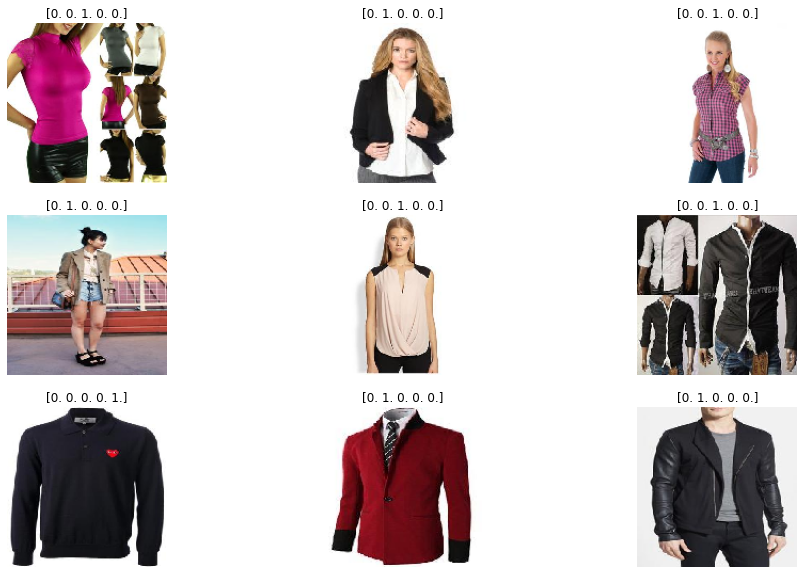

In [9]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in train_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title(labels_batch[i])
        plt.axis("off")        
    break

In [10]:
def base_model() -> Sequential:
    model = Sequential()
    model.add(Input((150, 150, 3)))    
    # Conv2D Layer
    model.add(Conv2D(filters=32, kernel_size=5, padding='same'))
    model.add(Activation('relu'))    
    model.add(SpatialDropout2D(0.5))

    # BatchNormalization
    model.add(BatchNormalization())
    model.add(Activation('relu'))    

    # Max Pooling
    model.add(MaxPooling2D(pool_size=(5, 5), strides = 5))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(5, activation='softmax'))
    
    return model  

In [11]:
METRICS = [
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR')
]

model = base_model()
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

In [12]:
number_epochs = 3
early_stoppage = EarlyStopping(monitor='val_loss', patience=3)
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2, min_lr=0.0001)
history = model.fit(
    train_gen,
    epochs=number_epochs,
    validation_data=val_gen,
    callbacks=[variable_learning_rate, early_stoppage]    
)

Epoch 1/3
282/282 [==============================] - 38s 124ms/step - loss: 0.8897 - accuracy: 0.8784 - precision: 0.7391 - recall: 0.6062 - auc: 0.9112 - prc: 0.6851 - val_loss: 69.5081 - val_accuracy: 0.8960 - val_precision: 0.7400 - val_recall: 0.7398 - val_auc: 0.8375 - val_prc: 0.6351
Epoch 2/3
282/282 [==============================] - 33s 115ms/step - loss: 0.7642 - accuracy: 0.8888 - precision: 0.7488 - recall: 0.6683 - auc: 0.9258 - prc: 0.7172 - val_loss: 73.9112 - val_accuracy: 0.8959 - val_precision: 0.7398 - val_recall: 0.7398 - val_auc: 0.8375 - val_prc: 0.6351
Epoch 3/3
282/282 [==============================] - 33s 116ms/step - loss: 0.7337 - accuracy: 0.8910 - precision: 0.7469 - recall: 0.6880 - auc: 0.9294 - prc: 0.7284 - val_loss: 105.9989 - val_accuracy: 0.8959 - val_precision: 0.7398 - val_recall: 0.7398 - val_auc: 0.8374 - val_prc: 0.6351

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


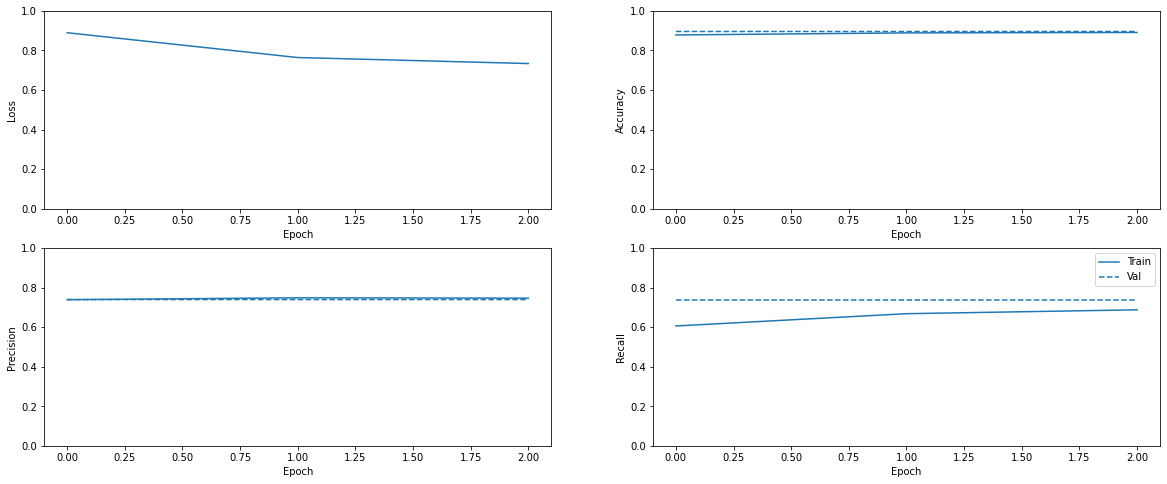

In [13]:
plot_metrics(history)

In [49]:
from typing import List
def one_hot_encode_labels(labels: List[int]) -> np.array:
    class_no = len(np.unique(np.array(labels)))
    print(class_no)
    output = np.zeros((len(labels), class_no))
    print(output.shape)
    for idx, v in enumerate(labels):
      output[idx][v] = 1.0
    return output

y_test = one_hot_encode_labels(test_gen.labels)

5
(6001, 5)


In [50]:
y_pred = model.predict(test_gen)

In [34]:
from sklearn.metrics import top_k_accuracy_score, balanced_accuracy_score, accuracy_score

In [55]:
y_test

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [60]:
y_pred[0]

array([0., 0., 1., 0., 0.], dtype=float32)

In [67]:
output = list(map(lambda x: list(x).index(max(x)), y_test)) 

In [62]:
output = list(map(lambda x: list(x).index(max(x)), y_pred)) 

In [64]:
y_pred

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 4.4344228e-33, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 1.0254765e-31, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [69]:
np.unique(np.array(output))

array([0, 1, 2, 3, 4])

In [77]:

compute_score("Test Dataset", y_test, y_pred)


(Test Dataset) ROC: 0.5050786043839894, AUPRC: 0.205613087126072
(Test Dataset) Accuracy: 0.7398766872187968 Balanced Accuracy: 0.2
